<a href="https://colab.research.google.com/github/No0bDarren/ADALL_github/blob/main/ADALL_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from pathlib import Path

data_path = Path(r"C:\Users\darre\Desktop\Python\School Project\diabetes_012_health_indicators_BRFSS2015.csv")
df = pd.read_csv(data_path)

print("Shape:", df.shape)
print("Missing values:\n", df.isna().sum())
print("Target counts:\n", df["Diabetes_012"].value_counts().sort_index())
print("Target %:\n", (df["Diabetes_012"].value_counts(normalize=True).sort_index() * 100).round(2))

Shape: (253680, 22)
Missing values:
 Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64
Target counts:
 Diabetes_012
0.0    213703
1.0      4631
2.0     35346
Name: count, dtype: int64
Target %:
 Diabetes_012
0.0    84.24
1.0     1.83
2.0    13.93
Name: proportion, dtype: float64


## Step 2 - Basic EDA (distributions + class balance)

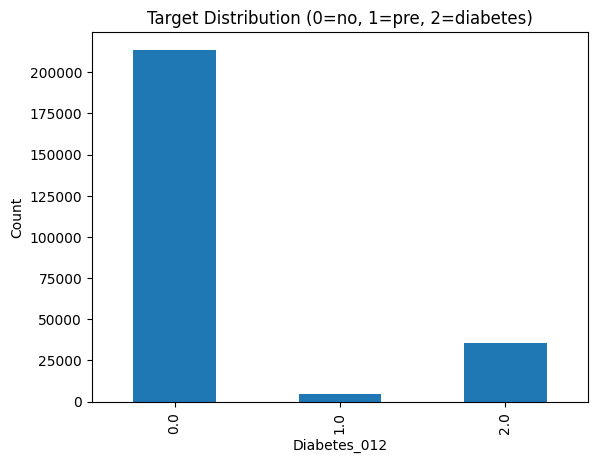

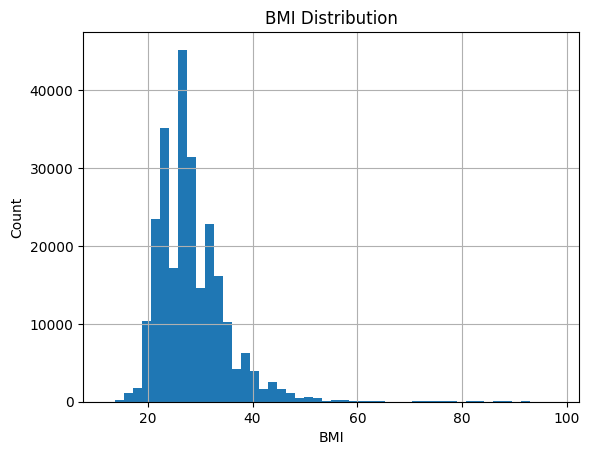

In [ ]:
import matplotlib.pyplot as plt

# Target distribution
ax = df["Diabetes_012"].value_counts().sort_index().plot(kind="bar")
ax.set_title("Target Distribution (0=no, 1=pre, 2=diabetes)")
ax.set_xlabel("Diabetes_012")
ax.set_ylabel("Count")
plt.show()

# BMI distribution
ax = df["BMI"].hist(bins=50)
plt.title("BMI Distribution")
plt.xlabel("BMI")
plt.ylabel("Count")
plt.show()

## Step 3 - Train/test split (stratified)

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Diabetes_012"])
y = df["Diabetes_012"]

# 70/15/15 split (train/val/test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Feature engineering: Age group (>=40 vs <40)
# Age is ordinal bins; treat Age >= 8 as approx >= 40 years
for _df in (X_train, X_val, X_test):
    _df["AgeOver40"] = (_df["Age"] >= 8).astype(int)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (177576, 22)
Val shape: (38052, 22)
Test shape: (38052, 22)


## Step 3b - Preprocessing (log transform skewed + preserve ordinal order)


In [ ]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# Skewed continuous features (right-skew)
skewed_cols = ["BMI", "MentHlth", "PhysHlth"]

# Ordinal features are kept as ordered numeric codes
ordinal_cols = ["Age", "Education", "Income", "GenHlth"]

preprocess = ColumnTransformer(
    transformers=[
        ("log", FunctionTransformer(np.log1p, feature_names_out="one-to-one"), skewed_cols),
    ],
    remainder="passthrough"
)

X_train_p = preprocess.fit_transform(X_train)
X_val_p = preprocess.transform(X_val)
X_test_p = preprocess.transform(X_test)

feature_names = preprocess.get_feature_names_out()
X_train_p_df = pd.DataFrame(X_train_p, columns=feature_names)
X_val_p_df = pd.DataFrame(X_val_p, columns=feature_names)
X_test_p_df = pd.DataFrame(X_test_p, columns=feature_names)

print("Transformed shape:", X_train_p_df.shape)
print("Example transformed columns:", list(feature_names)[:10])


Transformed shape: (177576, 22)
Example transformed columns: ['log__BMI', 'log__MentHlth', 'log__PhysHlth', 'remainder__HighBP', 'remainder__HighChol', 'remainder__CholCheck', 'remainder__Smoker', 'remainder__Stroke', 'remainder__HeartDiseaseorAttack', 'remainder__PhysActivity']


## Step 3d - Balance training set with SMOTE (synthetic data)


In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE

print("Class counts before SMOTE:", Counter(y_train))

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_p_df, y_train)

print("Class counts after SMOTE:", Counter(y_train_sm))


Class counts before SMOTE: Counter({0.0: 149592, 2.0: 24742, 1.0: 3242})
Class counts after SMOTE: Counter({0.0: 149592, 2.0: 149592, 1.0: 149592})


## Step 3c - Transformation impact (macro F1: raw vs log)


In [ ]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Raw (no log transform) baseline
scaler_raw = StandardScaler()
X_train_raw_s = scaler_raw.fit_transform(X_train)
X_val_raw_s = scaler_raw.transform(X_val)

logreg_raw = LogisticRegression(max_iter=1000, multi_class="auto")
logreg_raw.fit(X_train_raw_s, y_train)
raw_preds = logreg_raw.predict(X_val_raw_s)
raw_f1 = f1_score(y_val, raw_preds, average="macro")

# Log-transformed baseline (uses preprocess outputs)
scaler_log = StandardScaler()
X_train_log_s = scaler_log.fit_transform(X_train_p)
X_val_log_s = scaler_log.transform(X_val_p)

logreg_log = LogisticRegression(max_iter=1000, multi_class="auto")
logreg_log.fit(X_train_log_s, y_train)
log_preds = logreg_log.predict(X_val_log_s)
log_f1 = f1_score(y_val, log_preds, average="macro")

print(f"Macro-F1 (raw): {raw_f1:.4f}")
print(f"Macro-F1 (log): {log_f1:.4f}")
print(f"Delta (log - raw): {log_f1 - raw_f1:.4f}")

c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Macro-F1 (raw): 0.3919
Macro-F1 (log): 0.3957
Delta (log - raw): 0.0038


## Step 4 - Baseline model pipeline (Logistic Regression)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_p)
X_val_s = scaler.transform(X_val_p)
X_test_s = scaler.transform(X_test_p)

baseline = LogisticRegression(max_iter=1000, multi_class="auto")
baseline.fit(X_train_s, y_train)

c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'auto'


## Step 5 - Evaluate baseline

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = baseline.predict(X_test_s)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.97      0.92     32055
         1.0       0.00      0.00      0.00       695
         2.0       0.54      0.19      0.28      5302

    accuracy                           0.85     38052
   macro avg       0.47      0.39      0.40     38052
weighted avg       0.80      0.85      0.81     38052

[[31248     0   807]
 [  631     0    64]
 [ 4295     0  1007]]


c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

## Step 6 - Second model (Random Forest)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200, random_state=42, class_weight="balanced"
)
rf.fit(X_train_p_df, y_train)

y_pred_rf = rf.predict(X_test_p_df)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91     32055
         1.0       0.00      0.00      0.00       695
         2.0       0.48      0.16      0.24      5302

    accuracy                           0.84     38052
   macro avg       0.45      0.38      0.38     38052
weighted avg       0.79      0.84      0.80     38052



## Step 6b - Third model (XGBoost)


In [ ]:
try:
    from xgboost import XGBClassifier
except ImportError as e:
    raise ImportError("xgboost not installed. Install with: pip install xgboost") from e

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    random_state=42
)

xgb.fit(X_train_p_df, y_train)
y_pred_xgb = xgb.predict(X_test_p_df)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92     32055
         1.0       0.00      0.00      0.00       695
         2.0       0.57      0.19      0.29      5302

    accuracy                           0.85     38052
   macro avg       0.48      0.39      0.40     38052
weighted avg       0.81      0.85      0.81     38052



c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

## Step 7 - GridSearch tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight="balanced"),
    param_grid=param_grid,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1
)

grid.fit(X_train_p_df, y_train)
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

# Validate on holdout validation set
from sklearn.metrics import classification_report
best_rf = grid.best_estimator_
y_val_pred = best_rf.predict(X_val_p_df)
print("Validation report:\n", classification_report(y_val, y_val_pred))

Best params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best CV score: 0.435207327147761
Validation report:
               precision    recall  f1-score   support

         0.0       0.88      0.93      0.90     32056
         1.0       0.00      0.00      0.00       694
         2.0       0.44      0.36      0.40      5302

    accuracy                           0.83     38052
   macro avg       0.44      0.43      0.43     38052
weighted avg       0.81      0.83      0.82     38052



## Step 8 - Explainability (feature importance)

In [ ]:
import pandas as pd

best_rf = grid.best_estimator_
importances = pd.Series(best_rf.feature_importances_, index=feature_names).sort_values(ascending=False)
print(importances.head(10))

log__BMI                0.173852
remainder__Age          0.115345
remainder__Income       0.096682
log__PhysHlth           0.078184
remainder__GenHlth      0.076372
remainder__Education    0.067983
log__MentHlth           0.065638
remainder__HighBP       0.037840
remainder__Smoker       0.034387
remainder__Fruits       0.033864
dtype: float64


## Step 9 - Error analysis (misclassifications)

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Use best_rf for error analysis by default
best_model = best_rf

y_pred_best = best_model.predict(X_test_p_df)
cm = confusion_matrix(y_test, y_pred_best, labels=[0, 1, 2])
print("Confusion matrix (rows=true, cols=pred):\n", cm)

# Error profiles: compare feature means for misclassified vs correctly classified
errors = X_test_p_df.copy()
errors["true"] = y_test.values
errors["pred"] = y_pred_best

misclassified = errors[errors["true"] != errors["pred"]]
correct = errors[errors["true"] == errors["pred"]]

# Aggregate top differences
feature_cols = list(feature_names)
mis_means = misclassified[feature_cols].mean()
cor_means = correct[feature_cols].mean()

diff = (mis_means - cor_means).abs().sort_values(ascending=False)
print("Top features where misclassified differ from correct (abs mean diff):")
print(diff.head(10))

Confusion matrix (rows=true, cols=pred):
 [[29660    76  2319]
 [  528     0   167]
 [ 3271    16  2015]]
Top features where misclassified differ from correct (abs mean diff):
remainder__Age                     1.648190
remainder__Income                  0.811778
remainder__GenHlth                 0.777084
log__PhysHlth                      0.414764
remainder__HighBP                  0.368757
remainder__Education               0.302850
remainder__HighChol                0.274419
remainder__AgeOver40               0.238336
remainder__DiffWalk                0.191007
remainder__HeartDiseaseorAttack    0.121984
dtype: float64


## Step 10 - What-if analysis (sensitivity)

In [ ]:
# Adjust BMI for a single sample and see prediction changes
sample = X_test.iloc[[0]].copy()

for bmi in [25, 30, 35, 40]:
    sample["BMI"] = bmi
    sample_p = preprocess.transform(sample)
    sample_p_df = pd.DataFrame(sample_p, columns=feature_names)
    print("BMI:", bmi, "Pred:", best_rf.predict(sample_p_df)[0])

BMI: 25 Pred: 0.0
BMI: 30 Pred: 0.0
BMI: 35 Pred: 0.0
BMI: 40 Pred: 0.0


## Step 11 - Model comparison table (accuracy, macro F1, weighted F1)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

models = {
    "LogReg": (baseline, X_test_s),
    "RandomForest": (rf, X_test_p_df),
    "XGBoost": (xgb, X_test_p_df),
}

rows = []
for name, (model, X_eval) in models.items():
    preds = model.predict(X_eval)
    rows.append({
        "model": name,
        "accuracy": accuracy_score(y_test, preds),
        "f1_macro": f1_score(y_test, preds, average="macro"),
        "f1_weighted": f1_score(y_test, preds, average="weighted"),
    })

comparison = pd.DataFrame(rows).sort_values(by="f1_macro", ascending=False)
comparison

,model,accuracy,f1_macro,f1_weighted
2,XGBoost,0.850336,0.401111,0.812783
0,LogReg,0.847656,0.398825,0.810700
1,RandomForest,0.840061,0.383992,0.801657


### Model selection justification (fill after running)
- We selected **[MODEL]** because it improves macro-F1 by **[DELTA]** over the baseline while remaining explainable with SHAP/pFI.
- This supports the decision to **[DECISION]** for the persona, with transparent drivers and acceptable error trade-offs.


## Step 11b - Top drivers summary (for insights write-up)


In [ ]:
# Top drivers from SHAP (mean absolute)
import shap

# Limit SHAP to a small sample for speed
shap_sample_n = 200
X_shap = X_test_p_df.iloc[:shap_sample_n]

explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_shap)

class_idx = 1  # 0=no, 1=prediabetes, 2=diabetes
sv = shap_values[..., class_idx]
shap_abs = np.abs(sv.values).mean(axis=0)
shap_top = pd.Series(shap_abs, index=feature_names).sort_values(ascending=False).head(5)
print("Top SHAP features:\n", shap_top)


c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Top SHAP features:
 log__BMI                0.051038
remainder__Age          0.035876
remainder__Income       0.032156
log__PhysHlth           0.024619
remainder__Education    0.022838
dtype: float64


## Step 12 - Structured error analysis (confusion by class + top error profiles)

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Use best_rf for error analysis by default
best_model = best_rf

y_pred_best = best_model.predict(X_test_p_df)
cm = confusion_matrix(y_test, y_pred_best, labels=[0, 1, 2])
print("Confusion matrix (rows=true, cols=pred):\n", cm)

# Error profiles: compare feature means for misclassified vs correctly classified
errors = X_test_p_df.copy()
errors["true"] = y_test.values
errors["pred"] = y_pred_best

misclassified = errors[errors["true"] != errors["pred"]]
correct = errors[errors["true"] == errors["pred"]]

# Aggregate top differences
feature_cols = list(feature_names)
mis_means = misclassified[feature_cols].mean()
cor_means = correct[feature_cols].mean()

diff = (mis_means - cor_means).abs().sort_values(ascending=False)
print("Top features where misclassified differ from correct (abs mean diff):")
print(diff.head(10))

Confusion matrix (rows=true, cols=pred):
 [[29660    76  2319]
 [  528     0   167]
 [ 3271    16  2015]]
Top features where misclassified differ from correct (abs mean diff):
remainder__Age                     1.648190
remainder__Income                  0.811778
remainder__GenHlth                 0.777084
log__PhysHlth                      0.414764
remainder__HighBP                  0.368757
remainder__Education               0.302850
remainder__HighChol                0.274419
remainder__AgeOver40               0.238336
remainder__DiffWalk                0.191007
remainder__HeartDiseaseorAttack    0.121984
dtype: float64


## Step 13 - Permutation Feature Importance (pFI)

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    best_model, X_test_p_df, y_test,
    n_repeats=5, random_state=42, scoring="f1_macro"
)

importances = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=False)
print(importances.head(10))

remainder__GenHlth                 0.034420
log__BMI                           0.034384
remainder__HighBP                  0.026224
remainder__HighChol                0.015798
remainder__Age                     0.013554
remainder__Income                  0.004829
remainder__DiffWalk                0.004131
remainder__HeartDiseaseorAttack    0.003674
remainder__AgeOver40               0.003247
log__PhysHlth                      0.002402
dtype: float64


## Step 14 - SHAP (global + local explainability)

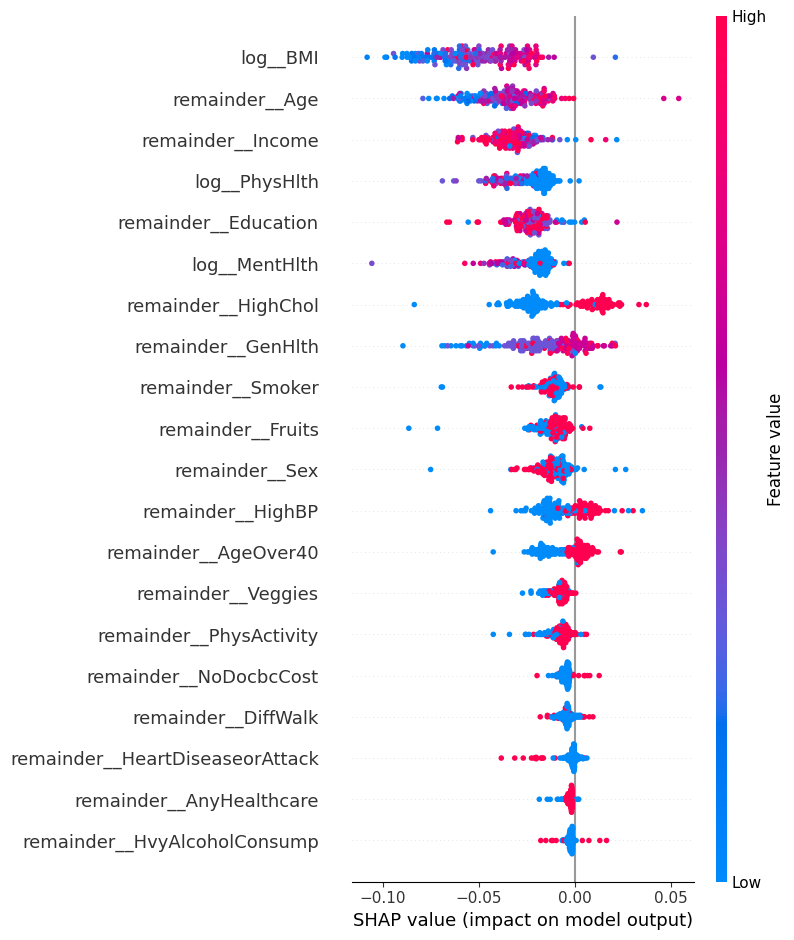

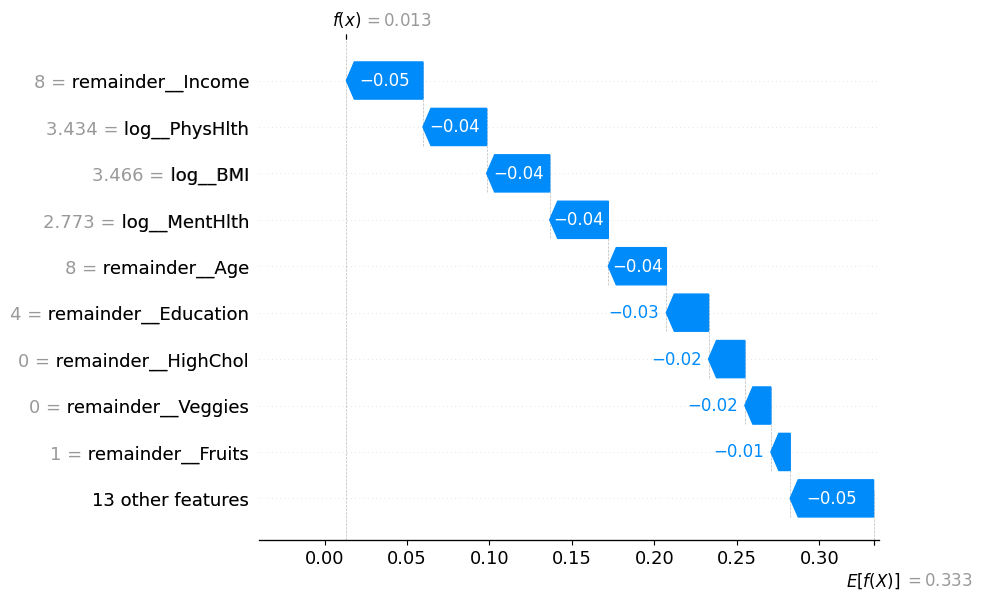

In [ ]:
try:
    import shap
except ImportError as e:
    raise ImportError("shap not installed. Install with: pip install shap") from e

# Use TreeExplainer for tree-based model
explainer = shap.TreeExplainer(best_model)

# Limit SHAP to a small sample for speed
shap_sample_n = 200
X_shap = X_test_p_df.iloc[:shap_sample_n]

# Prefer the new Explanation API (more stable across SHAP versions)
shap_values = explainer(X_shap)

# For multi-class, select the class to explain (1 = prediabetes)
class_idx = 1
sv = shap_values[..., class_idx]

# Global summary plot
shap.summary_plot(sv, X_shap)

# Local explanation for one sample
shap.plots.waterfall(sv[0])


In [ ]:
from sklearn.metrics import classification_report

# Class-weighted Logistic Regression
logreg_cw = LogisticRegression(max_iter=1000, multi_class="auto", class_weight="balanced")
logreg_cw.fit(X_train_s, y_train)
logreg_cw_preds = logreg_cw.predict(X_test_s)
print("LogReg class_weight=balanced")
print(classification_report(y_test, logreg_cw_preds))

# Class-weighted Random Forest
rf_cw = RandomForestClassifier(
    n_estimators=400, random_state=42, class_weight="balanced"
)
rf_cw.fit(X_train_p_df, y_train)
rf_cw_preds = rf_cw.predict(X_test_p_df)
print("RandomForest class_weight=balanced")
print(classification_report(y_test, rf_cw_preds))

c:\Users\darre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogReg class_weight=balanced
              precision    recall  f1-score   support

         0.0       0.95      0.66      0.78     32055
         1.0       0.03      0.30      0.05       695
         2.0       0.36      0.59      0.44      5302

    accuracy                           0.64     38052
   macro avg       0.45      0.52      0.43     38052
weighted avg       0.85      0.64      0.72     38052

RandomForest class_weight=balanced
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91     32055
         1.0       0.00      0.00      0.00       695
         2.0       0.48      0.15      0.23      5302

    accuracy                           0.84     38052
   macro avg       0.45      0.37      0.38     38052
weighted avg       0.79      0.84      0.80     38052



## Step 17 - SMOTE + model training (focus on class-1 recall)

In [ ]:
from sklearn.metrics import classification_report

# Train RF on SMOTE data from Step 3d
rf_sm = RandomForestClassifier(n_estimators=400, random_state=42)
rf_sm.fit(X_train_sm, y_train_sm)
rf_sm_preds = rf_sm.predict(X_test_p_df)
print("RandomForest + SMOTE")
print(classification_report(y_test, rf_sm_preds))


RandomForest + SMOTE
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     32055
         1.0       0.02      0.00      0.01       695
         2.0       0.44      0.31      0.37      5302

    accuracy                           0.83     38052
   macro avg       0.45      0.42      0.43     38052
weighted avg       0.80      0.83      0.82     38052



## Step 18 - Precision-Recall curve + threshold tuning for class 1

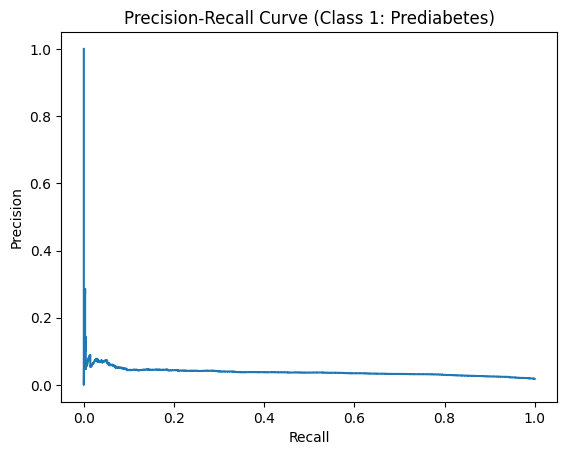

Selected threshold: 0.020403523
XGBoost threshold-tuned for class 1
              precision    recall  f1-score   support

         0.0       0.94      0.67      0.79     32055
         1.0       0.03      0.71      0.06       695
         2.0       0.67      0.02      0.04      5302

    accuracy                           0.58     38052
   macro avg       0.55      0.47      0.30     38052
weighted avg       0.89      0.58      0.67     38052



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, classification_report

# Use a probabilistic model (XGBoost) for threshold tuning
probs = xgb.predict_proba(X_test_p_df)
class1_probs = probs[:, 1]

precision, recall, thresholds = precision_recall_curve((y_test == 1).astype(int), class1_probs)

plt.plot(recall, precision)
plt.title("Precision-Recall Curve (Class 1: Prediabetes)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

# Choose threshold to maximize recall while keeping precision reasonable
# Example: choose threshold with recall >= 0.70 and highest precision
valid_idx = np.where(recall >= 0.70)[0]
if len(valid_idx) > 0:
    best_idx = valid_idx[np.argmax(precision[valid_idx])]
    best_thresh = thresholds[best_idx] if best_idx < len(thresholds) else thresholds[-1]
    print("Selected threshold:", best_thresh)
else:
    best_thresh = 0.5
    print("Fallback threshold:", best_thresh)

# Apply tuned threshold: predict class 1 when prob >= threshold, else fallback to argmax
preds = xgb.predict(X_test_p_df)
preds_tuned = preds.copy()
preds_tuned[class1_probs >= best_thresh] = 1

print("XGBoost threshold-tuned for class 1")
print(classification_report(y_test, preds_tuned))

## Step 19 - Consolidated model tracking (accuracy, macro-F1, class-1 recall, class-2 recall)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
import pandas as pd

rows = []

def add_row(name, model, X_eval, tuned_preds=None):
    preds = tuned_preds if tuned_preds is not None else model.predict(X_eval)
    rows.append({
        "model": name,
        "accuracy": accuracy_score(y_test, preds),
        "f1_macro": f1_score(y_test, preds, average="macro"),
        "recall_c1": recall_score(y_test, preds, labels=[1], average=None)[0],
        "recall_c2": recall_score(y_test, preds, labels=[2], average=None)[0],
    })

# Baselines
add_row("LogReg", baseline, X_test_s)
add_row("RandomForest", rf, X_test_p_df)
add_row("XGBoost", xgb, X_test_p_df)

# Tuned RF
add_row("RF_GridSearch", best_rf, X_test_p_df)

# Class-weighted
add_row("LogReg_class_weight", logreg_cw, X_test_s)
add_row("RF_class_weight", rf_cw, X_test_p_df)

# SMOTE RF
add_row("RF_SMOTE", rf_sm, X_test_p_df)

# Threshold-tuned XGBoost
add_row("XGB_threshold_tuned", xgb, X_test_p_df, tuned_preds=preds_tuned)

tracking = pd.DataFrame(rows).sort_values(by=["recall_c1", "f1_macro"], ascending=False)
tracking

,model,accuracy,f1_macro,recall_c1,recall_c2
7,XGB_threshold_tuned,0.583517,0.297107,0.706475,0.021879
4,LogReg_class_weight,0.644013,0.425942,0.297842,0.593927
6,RF_SMOTE,0.833360,0.426588,0.002878,0.313844
3,RF_GridSearch,0.832414,0.438851,0.000000,0.380045
2,XGBoost,0.850336,0.401111,0.000000,0.191060
0,LogReg,0.847656,0.398825,0.000000,0.189928
1,RandomForest,0.840061,0.383992,0.000000,0.160317
5,RF_class_weight,0.839824,0.381106,0.000000,0.152961
